# Train Target Model

In [1]:
import pandas as pd
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.base import clone
from sklearn.metrics import r2_score
import shap
import optuna
import sglearn
from scipy import stats
from datetime import datetime
import numpy as np
import plotnine as gg

from datasets import dataset_list
import target_featurization as ft

In [2]:
def lgbm_training_iteration(fold_df, train_index, features,
                            aa_seq_df, protein_domain_df,
                            conservation_df,
                            test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param features: list, features to us
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :param test_index: list-like
    :param base_model: LGBMRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seq_df,
                                                                      protein_domain_df=protein_domain_df,
                                                                      conservation_df=conservation_df)
    X_train_val = train_feature_df[train_feature_cols] # train and validation data
    y_train_val = train_df['Residual Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(test_df,
                                                                    features=features,
                                                                    aa_seq_df=aa_seq_df,
                                                                    protein_domain_df=protein_domain_df,
                                                                    conservation_df=conservation_df)
    X_test = test_feature_df[test_feature_cols]
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    r2 = r2_score(test_predictions['Residual Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(train_df, features, aa_seq_df, protein_domain_df, conservation_df):
    """Get objective function for training a lgbm model

    :param train_df: DataFrame
    :param features: list
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                              num_leaves=num_leaves,
                              min_child_samples=min_child_samples)
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (train_df, train_index, features,
                                          aa_seq_df, protein_domain_df,
                                          conservation_df,
                                          test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(train_df, train_df.dataset, train_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective

## Reading Data

In [3]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')
seq_model = joblib.load('../models/RuleSet3.pkl')

### Rename Database Columns

In [4]:
aa_seqs = aa_seqs.rename({'query': 'Transcript Base'}, axis=1)
protein_domains = protein_domains.rename({'Parent': 'Transcript Base'}, axis=1)

## Loading Datasets

In [5]:
train_data_list = list()
for ds in dataset_list:
    if (ds.name in train_data_names) and ds.endogenous:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()


## Merging Training Data

In [6]:
sg_df_list = []
for ds in tqdm(train_data_list):
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    design_df = ds.get_designs()
    sg_df = sg_df.merge(design_df, how='inner',
                        on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

100%|██████████| 4/4 [00:13<00:00,  3.31s/it]


Context sequences with multiple targets: 0


In [7]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])
                      .reset_index(drop=True))
sg_df_class_groups = ft.add_target_columns(sg_df_class_groups)

## Read Conservation Data

In [8]:
transcript_bases = list(sg_df_class_groups['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))
conservation_df['ranked_conservation'] = (conservation_df.groupby('Transcript Base')
                                          ['conservation']
                                          .rank(pct=True))

## Calculate Residuals

In [9]:
sg_df_residuals = sg_df_class_groups.copy()
sg_df_residuals['sgRNA Activity'] = (sg_df_residuals.groupby('dataset')
                                     ['sgRNA Activity']
                                     .rank(pct=True))
seq_X = sglearn.featurize_guides(sg_df_residuals['sgRNA Context Sequence'])
sg_df_residuals['Rule Set 3'] = seq_model.predict(seq_X)
(sg_df_residuals.groupby('dataset')
 .apply(lambda df: stats.pearsonr(df['Rule Set 3'], df['sgRNA Activity'])))

dataset
Doench2014_human     (0.7747588150394162, 6.327280047472541e-200)
Doench2014_mouse    (0.7221909327038771, 4.8841724249361805e-189)
Doench2016                        (0.6639725734142461, 3.06e-322)
Wang2014              (0.740204397054155, 4.967999241925921e-178)
dtype: object

In [10]:
sg_df_residuals['Residual Activity'] = sg_df_residuals['sgRNA Activity'] - sg_df_residuals['Rule Set 3']

In [11]:
## Training Model

In [12]:
features = ['position', 'aa', 'domain', 'conservation']
n_trials = 50

In [13]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
objective = get_lgbm_objective(sg_df_residuals, features=features,
                               aa_seq_df=aa_seqs, protein_domain_df=protein_domains,
                               conservation_df=conservation_df)
start_time = datetime.now()
study.optimize(objective, n_trials=n_trials)
end_time = datetime.now()
difference = end_time - start_time
print("Number of finished trials: {}".format(len(study.trials)))
print("Training Time: " + str(difference))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Using optimal parameters, retrain model with full dataset
train_feature_df, train_feature_cols = ft.build_target_feature_df(sg_df_residuals,
                                                                  features=features,
                                                                  aa_seq_df=aa_seqs,
                                                                  protein_domain_df=protein_domains,
                                                                  conservation_df=conservation_df)
X_train_val = train_feature_df[train_feature_cols] # train and validation data
y_train_val = sg_df_residuals['Residual Activity']
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.1, random_state=7)
model = LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                      **trial.params)
model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=1000)

[I 2021-05-11 17:41:10,415] A new study created in memory with name: no-name-8ba3058e-260a-4fea-b29f-29421dd3ffe6
[I 2021-05-11 17:41:21,965] Trial 0 finished with value: 0.05272649144922661 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.05272649144922661.
[I 2021-05-11 17:41:30,496] Trial 1 finished with value: 0.05364278152790314 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 1 with value: 0.05364278152790314.
[I 2021-05-11 17:41:38,869] Trial 2 finished with value: 0.052602287064317424 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 1 with value: 0.05364278152790314.
[I 2021-05-11 17:41:48,590] Trial 3 finished with value: 0.03238874402970313 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 1 with value: 0.05364278152790314.
[I 2021-05-11 17:41:57,054] Trial 4 finished with value: 0.05511136791621614 and parameters: {'num_leaves': 74, 'min_child_samples'

Number of finished trials: 50
Training Time: 0:07:49.662525
Best trial:
  Value: 0.07213581446173441
  Params: 
    num_leaves: 8
    min_child_samples: 10
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.030928
Early stopping, best iteration is:
[1504]	valid_0's l2: 0.0305874


LGBMRegressor(learning_rate=0.01, min_child_samples=10, n_estimators=5000,
              n_jobs=8, num_leaves=8, random_state=7)

### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

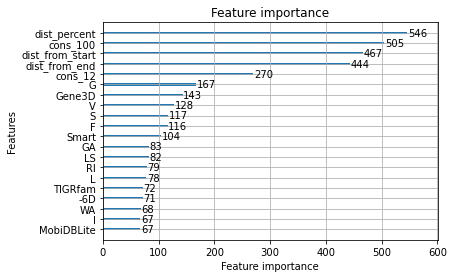

In [14]:
plot_importance(model, max_num_features=20)

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

* As a guide targets closer to the start of a protein, it is more likely to have a phenotypic consequence

* Guides targeting in the Smart protein domain are more likely to have a phenotype

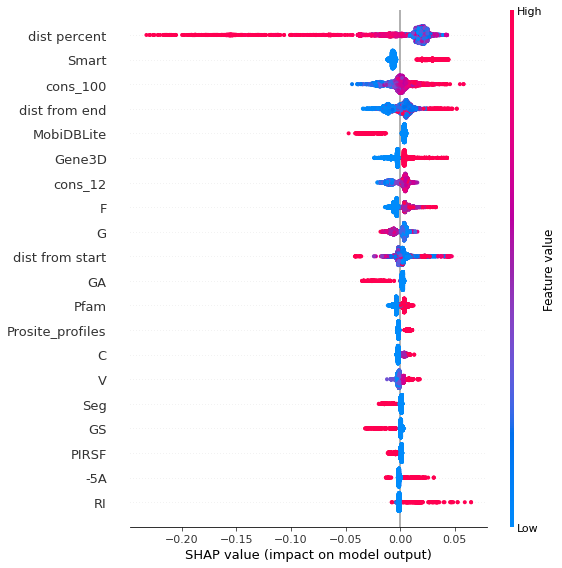

In [16]:
shap.summary_plot(shap_values, X_train)

<ipython-input-17-de318b40b7c2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


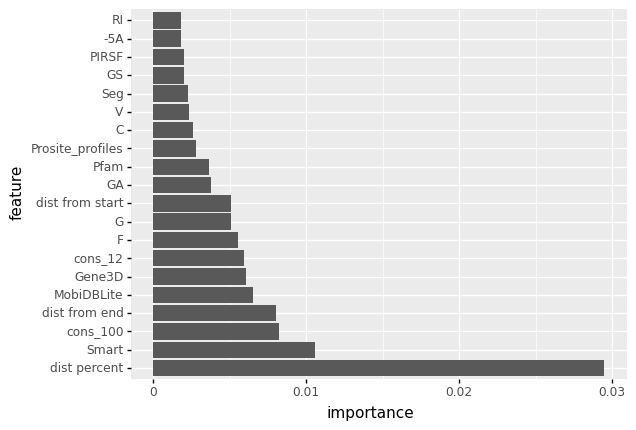

<ggplot: (8794721946344)>

In [17]:
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
shap_feature_importance = (shap_df.abs().mean(0)
                           .reset_index()
                           .rename({0: 'importance',
                                    'index': 'feature'}, axis=1)
                           .sort_values('importance', ascending=False))
top_n = 20
top_features = shap_feature_importance.head(top_n)
top_features['feature'] = pd.Categorical(top_features['feature'], categories=top_features['feature'])
(gg.ggplot(top_features) +
 gg.aes(x='feature', y='importance') +
 gg.geom_col() +
 gg.coord_flip())

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/pl

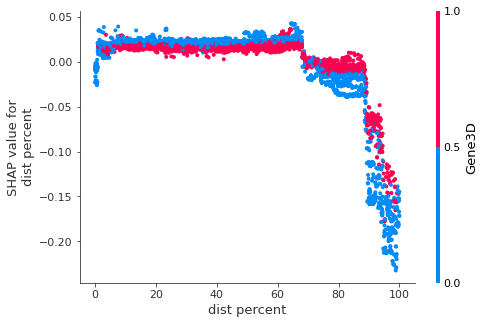

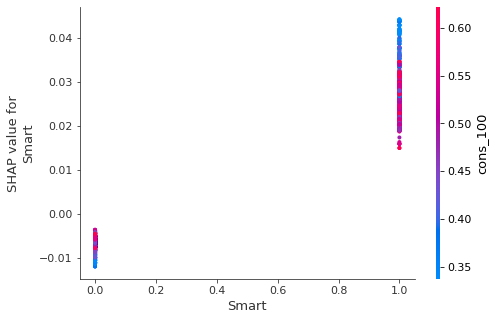

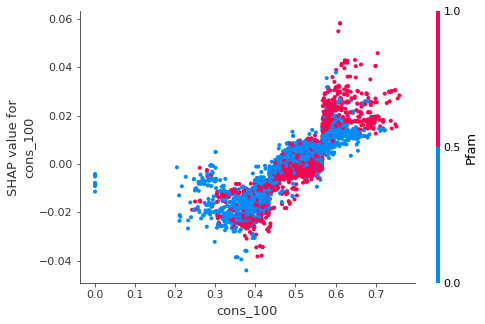

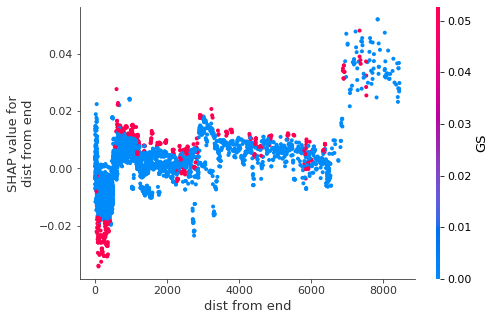

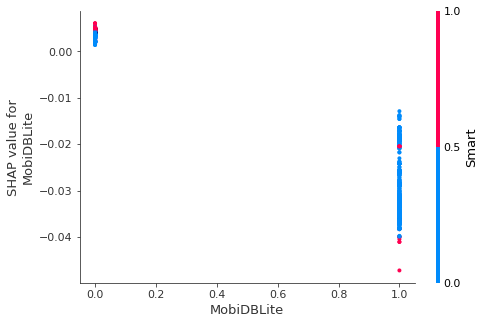

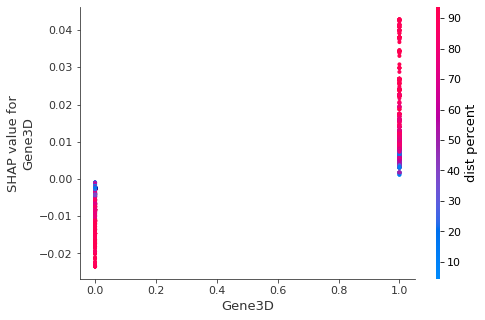

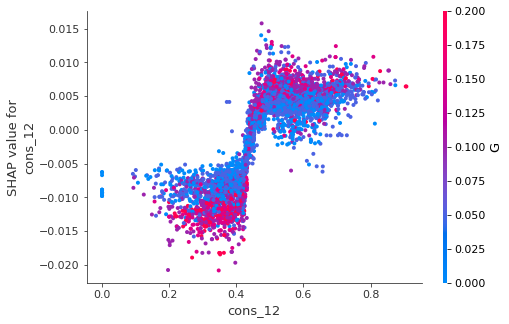

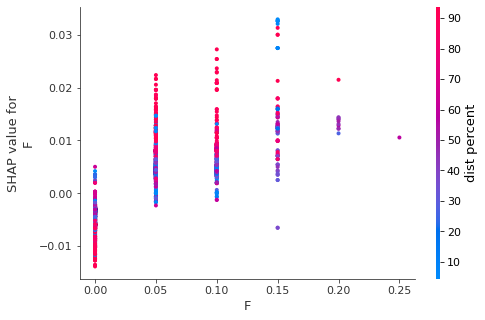

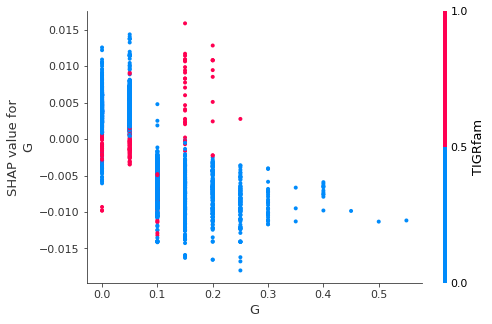

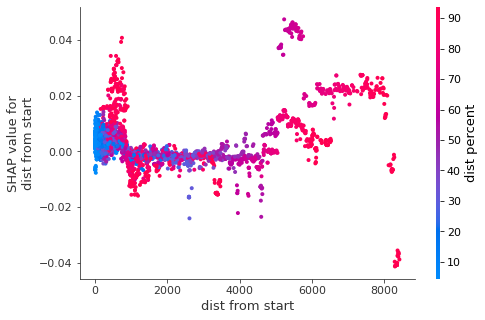

In [23]:
for feature in shap_feature_importance.head(10)['feature']:
    shap.dependence_plot(feature, shap_values, X_train)

In [25]:
shap_df.sort_values('Smart', ascending=False)

,dist from start,dist percent,sense,dist from end,Pfam,PANTHER,HAMAP,SuperFamily,TIGRfam,ncoils,...,10N,10P,10Q,10R,10S,10T,10V,10W,10Y,10*
116,-0.001252,0.021515,-0.001043,0.005087,-0.003514,0.000135,0.0,0.000390,0.000326,0.000600,...,0.0,-0.000013,0.0,0.0,-0.000003,0.000337,0.0,0.0,-0.000003,0.0
4764,-0.002009,0.021173,-0.001804,0.003245,-0.002216,0.000135,0.0,0.000486,0.000344,0.000650,...,0.0,-0.000013,0.0,0.0,-0.000003,-0.005117,0.0,0.0,-0.000003,0.0
2085,-0.002009,0.021173,0.001709,0.003245,-0.002216,0.000135,0.0,0.000486,0.000344,0.000650,...,0.0,-0.000013,0.0,0.0,-0.000003,-0.004647,0.0,0.0,-0.000003,0.0
4347,-0.001385,0.017922,-0.001169,0.007686,-0.000816,0.000107,0.0,0.000487,0.000493,0.000627,...,0.0,-0.000013,0.0,0.0,-0.000003,0.000288,0.0,0.0,-0.000003,0.0
4388,-0.001497,0.017490,-0.001281,0.007874,-0.001841,0.000107,0.0,0.000487,-0.000114,0.000627,...,0.0,-0.000013,0.0,0.0,-0.000003,0.000288,0.0,0.0,0.000077,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036,0.001785,0.035817,-0.001217,-0.000951,-0.003647,0.000135,0.0,0.000542,-0.000148,0.000525,...,0.0,-0.000013,0.0,0.0,-0.000038,0.000310,0.0,0.0,-0.000003,0.0
4444,0.006499,-0.075214,0.001154,0.007875,0.003856,0.000114,0.0,-0.000933,0.000132,0.000630,...,0.0,0.000110,0.0,0.0,-0.000029,0.000082,0.0,0.0,-0.000003,0.0
3303,0.007117,-0.066944,0.001105,0.007933,-0.004223,0.000118,0.0,-0.000935,0.000132,0.000630,...,0.0,-0.000013,0.0,0.0,-0.000003,0.000258,0.0,0.0,-0.000003,0.0
2692,0.007063,-0.065346,0.001164,0.007717,0.004003,0.000118,0.0,-0.000940,-0.000246,0.000630,...,0.0,-0.000013,0.0,0.0,-0.000002,0.000257,0.0,0.0,-0.000003,0.0


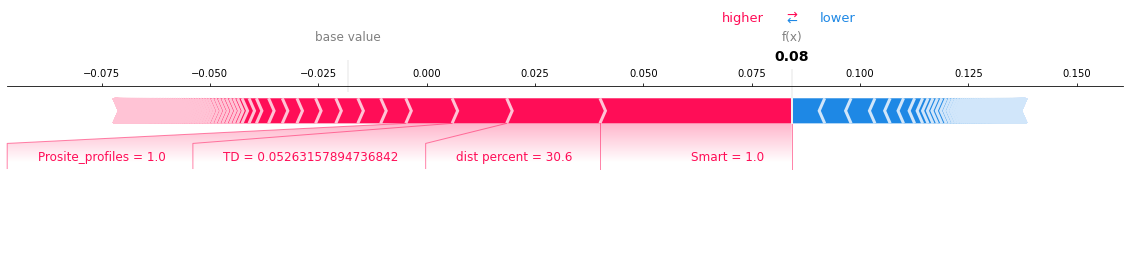

In [26]:
shap.force_plot(explainer.expected_value, shap_values[116,:], X_train.iloc[116,:],
                 matplotlib=True)


In [30]:
# TODO - set sgRNA Context as index?, Remove dist from start and dist from end as features

train_feature_df.loc[116,'Smart']

0.0

## Output Model

In [22]:
# joblib.dump(model, '../models/RuleSet3.pkl')